# [COM4513-6513] Assignment 1: Text Classification with Logistic Regression

### Instructor: Nikos Aletras


The goal of this assignment is to develop and test two text classification systems: 

- **Task 1:** sentiment analysis, in particular to predict the sentiment of movie review, i.e. positive or negative (binary classification).
- **Task 2:** topic classification, to predict whether a news article is about International issues, Sports or Business (multiclass classification).


For that purpose, you will implement:

- Text processing methods for extracting Bag-Of-Word features, using (1) unigrams, bigrams and trigrams to obtain vector representations of documents. Two vector weighting schemes should be tested: (1) raw frequencies (**3 marks; 1 for each ngram type**); (2) tf.idf (**1 marks**). 
- Binary Logistic Regression classifiers that will be able to accurately classify movie reviews trained with (1) BOW-count (raw frequencies); and (2) BOW-tfidf (tf.idf weighted) for Task 1. 
- Multiclass Logistic Regression classifiers that will be able to accurately classify news articles trained with (1) BOW-count (raw frequencies); and (2) BOW-tfidf (tf.idf weighted) for Task 2. 
- The Stochastic Gradient Descent (SGD) algorithm to estimate the parameters of your Logistic Regression models. Your SGD algorithm should:
    - Minimise the Binary Cross-entropy loss function for Task 1 (**3 marks**)
    - Minimise the Categorical Cross-entropy loss function for Task 2 (**3 marks**)
    - Use L2 regularisation (both tasks) (**1 mark**)
    - Perform multiple passes (epochs) over the training data (**1 mark**)
    - Randomise the order of training data after each pass (**1 mark**)
    - Stop training if the difference between the current and previous validation loss is smaller than a threshold (**1 mark**)
    - After each epoch print the training and development loss (**1 mark**)
- Discuss how did you choose hyperparameters (e.g. learning rate and regularisation strength)?  (**2 marks; 0.5 for each model in each task**).
- After training the LR models, plot the learning process (i.e. training and validation loss in each epoch) using a line plot (**1 mark; 0.5 for both BOW-count and BOW-tfidf LR models in each task**) and discuss if your model overfits/underfits/is about right.
- Model interpretability by showing the most important features for each class (i.e. most positive/negative weights). Give the top 10 for each class and comment on whether they make sense (if they don't you might have a bug!).  If we were to apply the classifier we've learned into a different domain such laptop reviews or restaurant reviews, do you think these features would generalise well? Can you propose what features the classifier could pick up as important in the new domain? (**2 marks; 0.5 for BOW-count and BOW-tfidf LR models respectively in each task**)


### Data - Task 1 

The data you will use for Task 1 are taken from here: [http://www.cs.cornell.edu/people/pabo/movie-review-data/](http://www.cs.cornell.edu/people/pabo/movie-review-data/) and you can find it in the `./data_sentiment` folder in CSV format:

- `data_sentiment/train.csv`: contains 1,400 reviews, 700 positive (label: 1) and 700 negative (label: 0) to be used for training.
- `data_sentiment/dev.csv`: contains 200 reviews, 100 positive and 100 negative to be used for hyperparameter selection and monitoring the training process.
- `data_sentiment/test.csv`: contains 400 reviews, 200 positive and 200 negative to be used for testing.

### Data - Task 2

The data you will use for Task 2 is a subset of the [AG News Corpus](http://groups.di.unipi.it/~gulli/AG_corpus_of_news_articles.html) and you can find it in the `./data_topic` folder in CSV format:

- `data_topic/train.csv`: contains 2,400 news articles, 800 for each class to be used for training.
- `data_topic/dev.csv`: contains 150 news articles, 50 for each class to be used for hyperparameter selection and monitoring the training process.
- `data_topic/test.csv`: contains 900 news articles, 300 for each class to be used for testing.


### Submission Instructions

You should submit a Jupyter Notebook file (assignment1.ipynb) and an exported PDF version (you can do it from Jupyter: `File->Download as->PDF via Latex`).

You are advised to follow the code structure given in this notebook by completing all given funtions. You can also write any auxilliary/helper functions (and arguments for the functions) that you might need but note that you can provide a full solution without any such functions. Similarly, you can just use only the packages imported below but you are free to use any functionality from the [Python Standard Library](https://docs.python.org/2/library/index.html), NumPy, SciPy and Pandas. You are not allowed to use any third-party library such as Scikit-learn (apart from metric functions already provided), NLTK, Spacy, Keras etc..

Please make sure to comment your code. You should also mention if you've used Windows (not recommended) to write and test your code. There is no single correct answer on what your accuracy should be, but correct implementations usually achieve F1-scores around 80\% or higher. The quality of the analysis of the results is as important as the accuracy itself. 

This assignment will be marked out of 20. It is worth 20\% of your final grade in the module.

The deadline for this assignment is **23:59 on Fri, 20 Mar 2020** and it needs to be submitted via MOLE. Standard departmental penalties for lateness will be applied. We use a range of strategies to detect [unfair means](https://www.sheffield.ac.uk/ssid/unfair-means/index), including Turnitin which helps detect plagiarism, so make sure you do not plagiarise.



In [301]:
# Total time to run the notebook is around 15/16 mins on a 2015 Macbook Pro
from datetime import datetime 
now = datetime.now()

import pandas as pd
import numpy as np
from collections import Counter
import re
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import random

# fixing random seed for reproducibility
random.seed(123)
np.random.seed(123)


## Load Raw texts and labels into arrays

First, you need to load the training, development and test sets from their corresponding CSV files (tip: you can use Pandas dataframes).

In [302]:
# Load training data with named columns 
data_sentiment_train = pd.read_csv("data_sentiment/train.csv", names=["Text", "Label"])
data_sentiment_test = pd.read_csv("data_sentiment/test.csv", names=["Text", "Label"])
data_sentiment_dev = pd.read_csv("data_sentiment/dev.csv", names=["Text", "Label"])

data_topic_train = pd.read_csv("data_topic/train.csv", names=["Label", "Text"])
data_topic_test = pd.read_csv("data_topic/test.csv", names=["Label", "Text"])
data_topic_dev = pd.read_csv("data_topic/dev.csv", names=["Label", "Text"])
                                        

If you use Pandas you can see a sample of the data.

In [303]:
data_sentiment_train.head()

,Text,Label
0,note : some may consider portions of the follo...,1
1,note : some may consider portions of the follo...,1
2,every once in a while you see a film that is s...,1
3,"when i was growing up in 1970s , boys in my sc...",1
4,"the muppet movie is the first , and the best m...",1


The next step is to put the raw texts into Python lists and their corresponding labels into NumPy arrays:


In [304]:
# Split data into lists and np arrays

# TRAINING DATA
data_sentiment_train_data = list(data_sentiment_train.loc[:,"Text"])
Y_tr = np.array(data_sentiment_train.loc[:,"Label"])


# TEST SET
data_sentiment_test_data = list(data_sentiment_test.loc[:,"Text"])
Y_test = np.array(data_sentiment_test.loc[:,"Label"])


# VALIDATION SET
data_sentiment_dev_data = list(data_sentiment_dev.loc[:,"Text"])
Y_dev = np.array(data_sentiment_dev.loc[:,"Label"])

# Bag-of-Words Representation 


To train and test Logisitc Regression models, you first need to obtain vector representations for all documents given a vocabulary of features (unigrams, bigrams, trigrams).


## Text Pre-Processing Pipeline

To obtain a vocabulary of features, you should: 
- tokenise all texts into a list of unigrams (tip: using a regular expression) 
- remove stop words (using the one provided or one of your preference) 
- compute bigrams, trigrams given the remaining unigrams
- remove ngrams appearing in less than K documents
- use the remaining to create a vocabulary of unigrams, bigrams and trigrams (you can keep top N if you encounter memory issues).


In [305]:
# stop_words = ['a','in','on','at','and','or', 
#               'to', 'the', 'of', 'an', 'by', 
#               'as', 'is', 'was', 'were', 'been', 'be', 
#               'are','for', 'this', 'that', 'these', 'those', 'you', 'i',
#              'it', 'he', 'she', 'we', 'they' 'will', 'have', 'has',
#               'do', 'did', 'can', 'could', 'who', 'which', 'what', 
#              'his', 'her', 'they', 'them', 'from', 'with', 'its']


# This list was found on GitHub here ------->    https://gist.github.com/sebleier/554280
# Also added days of the week which improved results for the muticlass model
# Cant see the list in the pdf because the line is too long
# Also removed days of the week as this increased the F1 measure for each classifier
stop_words = ["monday","tuesday","wednesday","thursday","friday","saturday","sunday","0o", "0s", "3a", "3b", "3d", "6b", "6o", "a", "a1", "a2", "a3", "a4", "ab", "able", "about", "above", "abst", "ac", "accordance", "according", "accordingly", "across", "act", "actually", "ad", "added", "adj", "ae", "af", "affected", "affecting", "affects", "after", "afterwards", "ag", "again", "against", "ah", "ain", "ain't", "aj", "al", "all", "allow", "allows", "almost", "alone", "along", "already", "also", "although", "always", "am", "among", "amongst", "amoungst", "amount", "an", "and", "announce", "another", "any", "anybody", "anyhow", "anymore", "anyone", "anything", "anyway", "anyways", "anywhere", "ao", "ap", "apart", "apparently", "appear", "appreciate", "appropriate", "approximately", "ar", "are", "aren", "arent", "aren't", "arise", "around", "as", "a's", "aside", "ask", "asking", "associated", "at", "au", "auth", "av", "available", "aw", "away", "awfully", "ax", "ay", "az", "b", "b1", "b2", "b3", "ba", "back", "bc", "bd", "be", "became", "because", "become", "becomes", "becoming", "been", "before", "beforehand", "begin", "beginning", "beginnings", "begins", "behind", "being", "believe", "below", "beside", "besides", "best", "better", "between", "beyond", "bi", "bill", "biol", "bj", "bk", "bl", "bn", "both", "bottom", "bp", "br", "brief", "briefly", "bs", "bt", "bu", "but", "bx", "by", "c", "c1", "c2", "c3", "ca", "call", "came", "can", "cannot", "cant", "can't", "cause", "causes", "cc", "cd", "ce", "certain", "certainly", "cf", "cg", "ch", "changes", "ci", "cit", "cj", "cl", "clearly", "cm", "c'mon", "cn", "co", "com", "come", "comes", "con", "concerning", "consequently", "consider", "considering", "contain", "containing", "contains", "corresponding", "could", "couldn", "couldnt", "couldn't", "course", "cp", "cq", "cr", "cry", "cs", "c's", "ct", "cu", "currently", "cv", "cx", "cy", "cz", "d", "d2", "da", "date", "dc", "dd", "de", "definitely", "describe", "described", "despite", "detail", "df", "di", "did", "didn", "didn't", "different", "dj", "dk", "dl", "do", "does", "doesn", "doesn't", "doing", "don", "done", "don't", "down", "downwards", "dp", "dr", "ds", "dt", "du", "due", "during", "dx", "dy", "e", "e2", "e3", "ea", "each", "ec", "ed", "edu", "ee", "ef", "effect", "eg", "ei", "eight", "eighty", "either", "ej", "el", "eleven", "else", "elsewhere", "em", "empty", "en", "end", "ending", "enough", "entirely", "eo", "ep", "eq", "er", "es", "especially", "est", "et", "et-al", "etc", "eu", "ev", "even", "ever", "every", "everybody", "everyone", "everything", "everywhere", "ex", "exactly", "example", "except", "ey", "f", "f2", "fa", "far", "fc", "few", "ff", "fi", "fifteen", "fifth", "fify", "fill", "find", "fire", "first", "five", "fix", "fj", "fl", "fn", "fo", "followed", "following", "follows", "for", "former", "formerly", "forth", "forty", "found", "four", "fr", "from", "front", "fs", "ft", "fu", "full", "further", "furthermore", "fy", "g", "ga", "gave", "ge", "get", "gets", "getting", "gi", "give", "given", "gives", "giving", "gj", "gl", "go", "goes", "going", "gone", "got", "gotten", "gr", "greetings", "gs", "gy", "h", "h2", "h3", "had", "hadn", "hadn't", "happens", "hardly", "has", "hasn", "hasnt", "hasn't", "have", "haven", "haven't", "having", "he", "hed", "he'd", "he'll", "hello", "help", "hence", "her", "here", "hereafter", "hereby", "herein", "heres", "here's", "hereupon", "hers", "herself", "hes", "he's", "hh", "hi", "hid", "him", "himself", "his", "hither", "hj", "ho", "home", "hopefully", "how", "howbeit", "however", "how's", "hr", "hs", "http", "hu", "hundred", "hy", "i", "i2", "i3", "i4", "i6", "i7", "i8", "ia", "ib", "ibid", "ic", "id", "i'd", "ie", "if", "ig", "ignored", "ih", "ii", "ij", "il", "i'll", "im", "i'm", "immediate", "immediately", "importance", "important", "in", "inasmuch", "inc", "indeed", "index", "indicate", "indicated", "indicates", "information", "inner", "insofar", "instead", "interest", "into", "invention", "inward", "io", "ip", "iq", "ir", "is", "isn", "isn't", "it", "itd", "it'd", "it'll", "its", "it's", "itself", "iv", "i've", "ix", "iy", "iz", "j", "jj", "jr", "js", "jt", "ju", "just", "k", "ke", "keep", "keeps", "kept", "kg", "kj", "km", "know", "known", "knows", "ko", "l", "l2", "la", "largely", "last", "lately", "later", "latter", "latterly", "lb", "lc", "le", "least", "les", "less", "lest", "let", "lets", "let's", "lf", "like", "liked", "likely", "line", "little", "lj", "ll", "ll", "ln", "lo", "look", "looking", "looks", "los", "lr", "ls", "lt", "ltd", "m", "m2", "ma", "made", "mainly", "make", "makes", "many", "may", "maybe", "me", "mean", "means", "meantime", "meanwhile", "merely", "mg", "might", "mightn", "mightn't", "mill", "million", "mine", "miss", "ml", "mn", "mo", "more", "moreover", "most", "mostly", "move", "mr", "mrs", "ms", "mt", "mu", "much", "mug", "must", "mustn", "mustn't", "my", "myself", "n", "n2", "na", "name", "namely", "nay", "nc", "nd", "ne", "near", "nearly", "necessarily", "necessary", "need", "needn", "needn't", "needs", "neither", "never", "nevertheless", "new", "next", "ng", "ni", "nine", "ninety", "nj", "nl", "nn", "no", "nobody", "non", "none", "nonetheless", "noone", "nor", "normally", "nos", "not", "noted", "nothing", "novel", "now", "nowhere", "nr", "ns", "nt", "ny", "o", "oa", "ob", "obtain", "obtained", "obviously", "oc", "od", "of", "off", "often", "og", "oh", "oi", "oj", "ok", "okay", "ol", "old", "om", "omitted", "on", "once", "one", "ones", "only", "onto", "oo", "op", "oq", "or", "ord", "os", "ot", "other", "others", "otherwise", "ou", "ought", "our", "ours", "ourselves", "out", "outside", "over", "overall", "ow", "owing", "own", "ox", "oz", "p", "p1", "p2", "p3", "page", "pagecount", "pages", "par", "part", "particular", "particularly", "pas", "past", "pc", "pd", "pe", "per", "perhaps", "pf", "ph", "pi", "pj", "pk", "pl", "placed", "please", "plus", "pm", "pn", "po", "poorly", "possible", "possibly", "potentially", "pp", "pq", "pr", "predominantly", "present", "presumably", "previously", "primarily", "probably", "promptly", "proud", "provides", "ps", "pt", "pu", "put", "py", "q", "qj", "qu", "que", "quickly", "quite", "qv", "r", "r2", "ra", "ran", "rather", "rc", "rd", "re", "readily", "really", "reasonably", "recent", "recently", "ref", "refs", "regarding", "regardless", "regards", "related", "relatively", "research", "research-articl", "respectively", "resulted", "resulting", "results", "rf", "rh", "ri", "right", "rj", "rl", "rm", "rn", "ro", "rq", "rr", "rs", "rt", "ru", "run", "rv", "ry", "s", "s2", "sa", "said", "same", "saw", "say", "saying", "says", "sc", "sd", "se", "sec", "second", "secondly", "section", "see", "seeing", "seem", "seemed", "seeming", "seems", "seen", "self", "selves", "sensible", "sent", "serious", "seriously", "seven", "several", "sf", "shall", "shan", "shan't", "she", "shed", "she'd", "she'll", "shes", "she's", "should", "shouldn", "shouldn't", "should've", "show", "showed", "shown", "showns", "shows", "si", "side", "significant", "significantly", "similar", "similarly", "since", "sincere", "six", "sixty", "sj", "sl", "slightly", "sm", "sn", "so", "some", "somebody", "somehow", "someone", "somethan", "something", "sometime", "sometimes", "somewhat", "somewhere", "soon", "sorry", "sp", "specifically", "specified", "specify", "specifying", "sq", "sr", "ss", "st", "still", "stop", "strongly", "sub", "substantially", "successfully", "such", "sufficiently", "suggest", "sup", "sure", "sy", "system", "sz", "t", "t1", "t2", "t3", "take", "taken", "taking", "tb", "tc", "td", "te", "tell", "ten", "tends", "tf", "th", "than", "thank", "thanks", "thanx", "that", "that'll", "thats", "that's", "that've", "the", "their", "theirs", "them", "themselves", "then", "thence", "there", "thereafter", "thereby", "thered", "therefore", "therein", "there'll", "thereof", "therere", "theres", "there's", "thereto", "thereupon", "there've", "these", "they", "theyd", "they'd", "they'll", "theyre", "they're", "they've", "thickv", "thin", "think", "third", "this", "thorough", "thoroughly", "those", "thou", "though", "thoughh", "thousand", "three", "throug", "through", "throughout", "thru", "thus", "ti", "til", "tip", "tj", "tl", "tm", "tn", "to", "together", "too", "took", "top", "toward", "towards", "tp", "tq", "tr", "tried", "tries", "truly", "try", "trying", "ts", "t's", "tt", "tv", "twelve", "twenty", "twice", "two", "tx", "u", "u201d", "ue", "ui", "uj", "uk", "um", "un", "under", "unfortunately", "unless", "unlike", "unlikely", "until", "unto", "uo", "up", "upon", "ups", "ur", "us", "use", "used", "useful", "usefully", "usefulness", "uses", "using", "usually", "ut", "v", "va", "value", "various", "vd", "ve", "ve", "very", "via", "viz", "vj", "vo", "vol", "vols", "volumtype", "vq", "vs", "vt", "vu", "w", "wa", "want", "wants", "was", "wasn", "wasnt", "wasn't", "way", "we", "wed", "we'd", "welcome", "well", "we'll", "well-b", "went", "were", "we're", "weren", "werent", "weren't", "we've", "what", "whatever", "what'll", "whats", "what's", "when", "whence", "whenever", "when's", "where", "whereafter", "whereas", "whereby", "wherein", "wheres", "where's", "whereupon", "wherever", "whether", "which", "while", "whim", "whither", "who", "whod", "whoever", "whole", "who'll", "whom", "whomever", "whos", "who's", "whose", "why", "why's", "wi", "widely", "will", "willing", "wish", "with", "within", "without", "wo", "won", "wonder", "wont", "won't", "words", "world", "would", "wouldn", "wouldnt", "wouldn't", "www", "x", "x1", "x2", "x3", "xf", "xi", "xj", "xk", "xl", "xn", "xo", "xs", "xt", "xv", "xx", "y", "y2", "yes", "yet", "yj", "yl", "you", "youd", "you'd", "you'll", "your", "youre", "you're", "yours", "yourself", "yourselves", "you've", "yr", "ys", "yt", "z", "zero", "zi", "zz"]

### N-gram extraction from a document

You first need to implement the `extract_ngrams` function. It takes as input:
- `x_raw`: a string corresponding to the raw text of a document
- `ngram_range`: a tuple of two integers denoting the type of ngrams you want to extract, e.g. (1,2) denotes extracting unigrams and bigrams.
- `token_pattern`: a string to be used within a regular expression to extract all tokens. Note that data is already tokenised so you could opt for a simple white space tokenisation.
- `stop_words`: a list of stop words
- `vocab`: a given vocabulary. It should be used to extract specific features.

and returns:

- a list of all extracted features.

See the examples below to see how this function should work.

In [306]:

# token_pattern was changed to allow ' marks and one letter tokens


def extract_ngrams(x_raw, ngram_range=(1,3), token_pattern=r"\b[A-Za-z\'][A-Za-z\']*\b", stop_words=[]):
    
    # To remove caps so to avoid e.g. This/this being seperate tokens   
    x_raw = x_raw.lower()
    
    # Tokenise document
    x_raw = re.findall(token_pattern,  x_raw)
    
    # filter out stopwords     
    tokens = [token for token in x_raw if token not in stop_words]
    
    # for each n-gram in ngram_range ---> construct a list of all n grams    
    sequences = []    
    for n in range(ngram_range[0], ngram_range[1] + 1) :   
        sequences.extend([tuple(tokens[i:i + n]) for i in range(len(tokens) - n + 1)])
        
        
    return sequences



In [307]:
extract_ngrams("this is a great movie to watch", 
               ngram_range=(1,3), 
               stop_words=stop_words)


[('great',),
 ('movie',),
 ('watch',),
 ('great', 'movie'),
 ('movie', 'watch'),
 ('great', 'movie', 'watch')]

In [308]:
extract_ngrams("this is a great movie to watch", 
               ngram_range=(1,3), 
               stop_words=stop_words)

[('great',),
 ('movie',),
 ('watch',),
 ('great', 'movie'),
 ('movie', 'watch'),
 ('great', 'movie', 'watch')]

In [309]:
extract_ngrams("this is a great movie to watch", 
               ngram_range=(1,2), 
               stop_words=stop_words)

[('great',), ('movie',), ('watch',), ('great', 'movie'), ('movie', 'watch')]

Note that it is OK to represent n-grams using lists instead of tuples: e.g. `['great', ['great', 'movie']]`

### Create a vocabulary of n-grams

Then the `get_vocab` function will be used to (1) create a vocabulary of ngrams; (2) count the document frequencies of ngrams; (3) their raw frequency. It takes as input:
- `X_raw`: a list of strings each corresponding to the raw text of a document
- `ngram_range`: a tuple of two integers denoting the type of ngrams you want to extract, e.g. (1,2) denotes extracting unigrams and bigrams.
- `token_pattern`: a string to be used within a regular expression to extract all tokens. Note that data is already tokenised so you could opt for a simple white space tokenisation.
- `stop_words`: a list of stop words
- `vocab`: a given vocabulary. It should be used to extract specific features.
- `min_df`: keep ngrams with a minimum document frequency.
- `keep_topN`: keep top-N more frequent ngrams.

and returns:

- `vocab`: a set of the n-grams that will be used as features.
- `df`: a Counter (or dict) that contains ngrams as keys and their corresponding document frequency as values.
- `ngram_counts`: counts of each ngram in vocab

Hint: it should make use of the `extract_ngrams` function.

In [310]:
def get_vocab(X_raw, ngram_range=(1,3), token_pattern=r'\b[A-Za-z\'][A-Za-z\']*\b', min_df=0, keep_topN=0, stop_words=[]):
    
    #  init empty values   
    df = dict()
    vocab = set()
    ngram_counts = []

    for x in X_raw : 
        # Get N-Grams for each document        
        v = extract_ngrams(x, ngram_range = ngram_range, token_pattern = token_pattern, stop_words = stop_words)
        
        # Add these ngrams to a list of words         
        ngram_counts.extend(v)
        
        # Remove duplications and add to the df dict accordingly   
        v = set(v)
        for item in list(v) :
            df[item] = df.get(item, 0) + 1
        
        # add the ngrams to the vocab        
        vocab |= v
    
    # Filter Document frequencies   
    df = {k: v for (k, v) in df.items() if v >= min_df}
    # Keep only the top N
    df = dict(list({k: v for (k, v) in sorted(df.items(), reverse = True, key=lambda x: x[1])}.items())[:keep_topN])
    
    # remove the filtered ngrams from the vocab
#     vocab = vocab.intersection(set(df.keys()))
    vocab = set(df.keys())
    # count the number of ngrams in the vocab 
    ngram_counts = [(x, y) for (x, y) in Counter(ngram_counts).items() if x in vocab]
    return vocab, df, ngram_counts


Now you should use `get_vocab` to create your vocabulary and get document and raw frequencies of n-grams:

In [311]:
vocab, df, ngram_counts = get_vocab(data_sentiment_train_data, ngram_range=(1,3), keep_topN=8000, stop_words=stop_words)

Then, you need to create vocabulary id -> word and word -> id dictionaries for reference:

In [312]:
# vocabulary id -> word and word -> id
v_id = {i: v for i, v in enumerate(vocab)}
w_id = {v: i for i, v in v_id.items()}


Now you should be able to extract n-grams for each text in the training, development and test sets:

In [313]:
tr_ngram_count = [extract_ngrams(x, stop_words=stop_words) for x in data_sentiment_train_data]
dev_ngram_count = [extract_ngrams(x, stop_words=stop_words) for x in data_sentiment_dev_data]
test_ngram_count = [extract_ngrams(x, stop_words=stop_words) for x in data_sentiment_test_data]

## Vectorise documents 

Next, write a function `vectoriser` to obtain Bag-of-ngram representations for a list of documents. The function should take as input:
- `X_ngram`: a list of texts (documents), where each text is represented as list of n-grams in the `vocab`
- `vocab`: a set of n-grams to be used for representing the documents

and return:
- `X_vec`: an array with dimensionality Nx|vocab| where N is the number of documents and |vocab| is the size of the vocabulary. Each element of the array should represent the frequency of a given n-gram in a document.


In [314]:
def vectorise(X_ngram, vocab):
    # Get size of vocab and X_ngram
    V = len(vocab)
    X = len(X_ngram)
    
    # Create an empty matrix  
    X_vec = np.zeros((X, V))
    
    # For each document construct a vector of size 1 x |V|  
    for doc_id, doc in enumerate(X_ngram) :
        doc = [d for d in doc if d in vocab]
        for word in doc :
            X_vec[doc_id, w_id[word]] += 1
    return X_vec

Finally, use `vectorise` to obtain document vectors for each document in the train, development and test set. You should extract both count and tf.idf vectors respectively:

#### Count vectors

In [315]:
# TRAINING COUNT MATRIX
X_tr_count = vectorise(tr_ngram_count, vocab)
# DEV COUNT MATRIX
X_dev_count = vectorise(dev_ngram_count, vocab)
# TEST COUNT MATRIX
X_test_count = vectorise(test_ngram_count, vocab)

In [316]:
X_tr_count.shape

(1400, 8000)

In [317]:
X_tr_count[:1,:50]

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2.,
        0., 0.]])

#### TF.IDF vectors

First compute `idfs` an array containing inverted document frequencies (Note: its elements should correspond to your `vocab`)

In [318]:
def tfidf(no_docs, df, v_id):
    # Get size of vocab and X_ngram
    V = len(v_id)
    # Create an empty matrix  
    X_vec = np.zeros((1, V))
    # For each document construct a vector of size 1 x |V|  
    for i in range(V) :
        X_vec[0, i] = np.log10(no_docs/df[v_id[i]])
    return X_vec


Then transform your count vectors to tf.idf vectors:

In [319]:
"""

Using the Count matrixes, enumerated vocabs, and the vocabs document frequencies
Calculate the TF.IDF for each value in the count matrixes

""" 

no_docs = len(tr_ngram_count)

idf = tfidf(no_docs, df, v_id)

X_tr_tfidf = np.log10(1 + X_tr_count) * idf
X_dev_tfidf = np.log10(1 + X_dev_count) * idf
X_test_tfidf = np.log10(1 + X_test_count) * idf


In [320]:
X_tr_tfidf.shape

(1400, 8000)

In [321]:
X_tr_tfidf[:1,:50]

array([[0.59304016, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.66698689, 0.        , 0.        ]])

# Binary Logistic Regression

After obtaining vector representations of the data, now you are ready to implement Binary Logistic Regression for classifying sentiment.

First, you need to implement the `sigmoid` function. It takes as input:

- `z`: a real number or an array of real numbers 

and returns:

- `sig`: the sigmoid of `z`

In [322]:
def sigmoid(z):
    z = 1 / (1 + np.exp(-z))
#     z = np.minimum(z, 0.9999)  # Set upper bound
#     z = np.maximum(z, 0.0001)  # Set lower bound
    return z

In [323]:
print(sigmoid(0)) 
print(sigmoid(np.array([-5., 1.2])))

0.5
[0.00669285 0.76852478]


In [324]:
print(sigmoid(0)) 
print(sigmoid(np.array([-5., 1.2])))

0.5
[0.00669285 0.76852478]


Then, implement the `predict_proba` function to obtain prediction probabilities. It takes as input:

- `X`: an array of inputs, i.e. documents represented by bag-of-ngram vectors ($N \times |vocab|$)
- `weights`: a 1-D array of the model's weights $(1, |vocab|)$

and returns:

- `preds_proba`: the prediction probabilities of X given the weights

In [325]:
def predict_proba(X, weights):
    # Use sigmoid to prodict the probability     
    preds_proba = np.dot(weights, X.T)
    return sigmoid(preds_proba)

Then, implement the `predict_class` function to obtain the most probable class for each vector in an array of input vectors. It takes as input:

- `X`: an array of documents represented by bag-of-ngram vectors ($N \times |vocab|$)
- `weights`: a 1-D array of the model's weights $(1, |vocab|)$

and returns:

- `preds_class`: the predicted class for each x in X given the weights

In [326]:
def predict_class(X, weights):
    # Return True if value is greater than 0.5 else 0    
    preds_proba = predict_proba(X, weights)
    return preds_proba > 0.5

To learn the weights from data, we need to minimise the binary cross-entropy loss. Implement `binary_loss` that takes as input:

- `X`: input vectors
- `Y`: labels
- `weights`: model weights
- `alpha`: regularisation strength

and return:

- `l`: the loss score

In [327]:
def binary_loss(X, Y, weights, alpha=0.00001):
    # Sum the binary loss     
    loss = 0
    for i, y in enumerate(Y) :
        prob = predict_proba(X[i], weights)
        loss += - np.log(prob) if y == 1 else - np.log(1 - prob)
    
    # Return the avg. loss and L2 regularisated    
    return loss/len(Y) + alpha * np.dot(weights,weights.T)


In [328]:
def binary_loss_dev(X, Y, weights, alpha=0.00001):
    
    # Calculate the gradient of the loss function     
    prob = predict_proba(X, weights)
    loss = X * (prob - Y)
    
    #  return the gradient of the loss fuction   
    return loss + 2 * alpha * weights

Now, you can implement Stochastic Gradient Descent to learn the weights of your sentiment classifier. The `SGD` function takes as input:

- `X_tr`: array of training data (vectors)
- `Y_tr`: labels of `X_tr`
- `X_dev`: array of development (i.e. validation) data (vectors)
- `Y_dev`: labels of `X_dev`
- `lr`: learning rate
- `alpha`: regularisation strength
- `epochs`: number of full passes over the training data
- `tolerance`: stop training if the difference between the current and previous validation loss is smaller than a threshold
- `print_progress`: flag for printing the training progress (train/validation loss)


and returns:

- `weights`: the weights learned
- `training_loss_history`: an array with the average losses of the whole training set after each epoch
- `validation_loss_history`: an array with the average losses of the whole development set after each epoch

In [329]:
def SGD(X_tr, Y_tr, X_dev=[], Y_dev=[], loss="binary", lr=0.1, alpha=0.00001, epochs=50, tolerance=0.0001, print_progress=True):
    
    training_loss_history = []
    validation_loss_history = []
    
    #  Init weights with zeros   
    weights = np.zeros(shape=(1, X_tr.shape[1]))
    
    # for each epoch     
    for e in range(epochs) :
        
        # Shuffle documents         
        s = np.arange(0, len(Y_tr))
        np.random.shuffle(s)
        
        # Shuffle the order of the docs        
        X = np.array(X_tr)[s]
        Y = np.array(Y_tr)[s]
        
        # For each document in the training data descend in the gradient space         
        for i, x in enumerate(X) :
            weights -= lr * binary_loss_dev(x, Y[i], weights,alpha=alpha)
        
        # Record the training and validation losses       
        training_loss_history.extend(binary_loss(X_tr, Y_tr, weights, alpha=alpha))        
        validation_loss_history.extend(binary_loss(X_dev, Y_dev, weights, alpha=alpha))
                 
        if print_progress :
            print("Epoch:", e,"| Training loss:", training_loss_history[e],"| Validation loss:", validation_loss_history[e])
        
        # Stop when the difference between the current and previous validation loss is smaller than a threshold      
        if e > 0 and np.abs(validation_loss_history[e - 1] - validation_loss_history[e]) < tolerance :
            break

    return weights, training_loss_history, validation_loss_history

## Train and Evaluate Logistic Regression with Count vectors

First train the model using SGD:

In [330]:
"""

A Naïve form of a grid-search to find good hyperparameters

"""
learning_rate = np.logspace(-1, -4, 4)
alpha = np.logspace(-1, -4, 4)

# Save best params in a hash
best = {"learning_rate" : 0, "Alpha" : 0, "f1" : 0} 

# for each hyperparam evaluate the model
for rate in learning_rate :
    for al in alpha :
        w_count, loss_tr_count, dev_loss_count = SGD(X_tr_count, Y_tr, 
                                            X_dev=X_dev_count, 
                                            Y_dev=Y_dev,  
                                            epochs=100,
                                            lr=rate,
                                            alpha=al,
                                            print_progress=False)
        
        # Evaluate         
        p = predict_class(X_test_count, w_count)
        f1 = f1_score(Y_test, p.squeeze() // 1)
        
        # if the F1 score is better than prev then replace      
        if f1 > best["f1"]:
             best = {"learning_rate" : rate, "Alpha" : al, "f1" : f1}

print("Final", best)

/Users/Jake/Documents/University/ComputerScience/YearFour/Text/env/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  
/Users/Jake/Documents/University/ComputerScience/YearFour/Text/env/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in subtract


Final {'learning_rate': 0.001, 'Alpha': 0.01, 'f1': 0.8564476885644767}


In [331]:
# Using optimal hyperparams train one last time
w_count, loss_tr_count, dev_loss_count = SGD(X_tr_count, Y_tr, 
                                             X_dev=X_dev_count, 
                                             Y_dev=Y_dev,  
                                             epochs=100,
                                                lr=best["learning_rate"],
                                                alpha=best["Alpha"])


Epoch: 0 | Training loss: [0.49440928] | Validation loss: [0.55627793]
Epoch: 1 | Training loss: [0.42064031] | Validation loss: [0.51709535]
Epoch: 2 | Training loss: [0.3744549] | Validation loss: [0.4964978]
Epoch: 3 | Training loss: [0.34402809] | Validation loss: [0.48802015]
Epoch: 4 | Training loss: [0.32568629] | Validation loss: [0.48100167]
Epoch: 5 | Training loss: [0.30595253] | Validation loss: [0.477951]
Epoch: 6 | Training loss: [0.29345698] | Validation loss: [0.47528786]
Epoch: 7 | Training loss: [0.28366447] | Validation loss: [0.47624076]
Epoch: 8 | Training loss: [0.27525469] | Validation loss: [0.47397944]
Epoch: 9 | Training loss: [0.26867319] | Validation loss: [0.47391554]


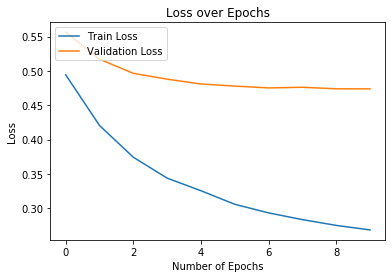

In [332]:

plt.plot(loss_tr_count,label='Train Loss')
plt.plot(dev_loss_count,label='Validation Loss')
plt.legend(loc="upper left")
plt.ylabel("Loss")
plt.xlabel("Number of Epochs")
plt.title("Loss over Epochs")
plt.show()

Now plot the training and validation history per epoch. Does your model underfit, overfit or is it about right? Explain why.

The model can be shown to be overfitting the data. This can be see by the differetn rate of loss between the validation and training losses. The rate of training loss is greater than that of the validation loss and the gap between plots increases overtime.

Compute accuracy, precision, recall and F1-scores:

In [333]:
def conf(pred, labels) :
    N = len(np.unique(labels)) # Number of classes 
    result = np.zeros((N, N))
    for i in range(len(Y_test)):
        result[labels[i]][pred[i]] += 1
    return result

In [334]:
# Make predictions
preds_te_count = predict_class(X_test_count, w_count)
# Convert to 1d vector of 1/0
preds_te_count = preds_te_count.squeeze()//1
print("Confusion Matrix")
print(conf(preds_te_count, Y_test))
print('Accuracy:', accuracy_score(Y_test, preds_te_count))
print('Precision:', precision_score(Y_test, preds_te_count))
print('Recall:', recall_score(Y_test, preds_te_count))
print('F1-Score:', f1_score(Y_test, preds_te_count))

Confusion Matrix
[[161.  39.]
 [ 23. 177.]]
Accuracy: 0.845
Precision: 0.8194444444444444
Recall: 0.885
F1-Score: 0.8509615384615384


Finally, print the top-10 words for the negative and positive class respectively.

In [335]:
pos = np.argsort(w_count)[0][::-1]
neg = np.argsort(w_count)[0]
print("Most Positive: ")
print([v_id[x] for x in pos[:10]])
print("Most Negative: ")
print([v_id[x] for x in neg[:10]])

Most Positive: 
[('great',), ('fun',), ('hilarious',), ('life',), ('movies',), ('perfect',), ('american',), ('true',), ('perfectly',), ('simple',)]
Most Negative: 
[('bad',), ('worst',), ('boring',), ('supposed',), ('plot',), ('script',), ('reason',), ('ridiculous',), ('stupid',), ('attempt',)]


comment on whether they make sense:

These Ngrams do make sense. The most positive words express positive sentiment such as "great" and "hilarious". As well as the most negative words being "bad" and "worst".

If we were to apply the classifier we've learned into a different domain such laptop reviews or restaurant reviews, do you think these features would generalise well? Can you propose what features the classifier could pick up as important in the new domain?

In terms of generalisabilty, this model could be used in an other domains like laptop reviews. Features such as "great", "simple", and "perfect" for positive sentiment as well as "bad", "worst", and "boring" for negative sentiment would be picked up as important. 

However, context specific features such as "movies" and "plot" suggests that the model has overfitted to movies and could struggle in other domains.  

### Discuss how did you choose model hyperparameters (e.g. learning rate and regularisation strength)? What is the relation between training epochs and learning rate? How the regularisation strength affects performance?

I chose my hyperparameters by using a very basic grid-search to go through a range of values (The ranges for both models were arbitrary for both models due to time taken to train the models). I went through each pair of values and evaluated its F1 score. I chose the pair that produced the highest F1 Score. If I had more time I would have tested more values as well as calculated an average for each pair to remove anomalous values.

Smaller learning rates require more training epochs as each update only changes the weights a little, whereas larger learning rates result in larger jumps so require fewer epochs.

A Regularisation value is a measure of the model's complexity. A Regularisation value encourages a model's weights, as well as its mean, to tend to zero. However, there is a trade-off with a large or small regularisation value. Too large and the model runs the risk of underfitting the data, and too small runs the risk of overfitting the data.

## Train and Evaluate Logistic Regression with TF.IDF vectors

Follow the same steps as above (i.e. evaluating count n-gram representations).


In [336]:
"""

A Naïve form of a grid-search to find good hyperparameters

"""

learning_rate = np.logspace(-2, -5, 4)
alpha = np.logspace(-2, -5, 4)

# Save best params in a hash
best = {"learning_rate" : 0, "Alpha" : 0, "f1" : 0} 

# for each hyperparam evaluate the model
for rate in learning_rate :
    for al in alpha :

        w_tfidf, trl, devl = SGD(X_tr_tfidf, Y_tr, 
                                             X_dev=X_dev_tfidf, 
                                             Y_dev=Y_dev,  
                                             epochs=100,
                                                lr=rate,
                                                    alpha=al,
                                                    print_progress=False)
        # Evaluate     
        p = predict_class(X_test_tfidf, w_tfidf)
        f1 = f1_score(Y_test, p.squeeze() // 1)
        
        # if the F1 score is better than prev then replace      
        if f1 > best["f1"]:
             best = {"learning_rate" : rate, "Alpha" : al, "f1" : f1}
                    
print("Final", best)

Final {'learning_rate': 0.01, 'Alpha': 1e-05, 'f1': 0.874074074074074}


In [337]:
# Using optimal hyperparams train one last time on tf.idf
w_tfidf, trl, devl = SGD(X_tr_tfidf, Y_tr, 
                         X_dev=X_dev_tfidf, 
                         Y_dev=Y_dev,
                         epochs=200,
                         lr=best["learning_rate"],
                        alpha=best["Alpha"])

Epoch: 0 | Training loss: [0.49443372] | Validation loss: [0.59017414]
Epoch: 1 | Training loss: [0.39457887] | Validation loss: [0.53981015]
Epoch: 2 | Training loss: [0.33190666] | Validation loss: [0.50844918]
Epoch: 3 | Training loss: [0.28771364] | Validation loss: [0.48713464]
Epoch: 4 | Training loss: [0.25461255] | Validation loss: [0.47159972]
Epoch: 5 | Training loss: [0.22862585] | Validation loss: [0.45916746]
Epoch: 6 | Training loss: [0.20772113] | Validation loss: [0.44837382]
Epoch: 7 | Training loss: [0.19023266] | Validation loss: [0.44046194]
Epoch: 8 | Training loss: [0.1756368] | Validation loss: [0.43401405]
Epoch: 9 | Training loss: [0.16313011] | Validation loss: [0.42790424]
Epoch: 10 | Training loss: [0.15230997] | Validation loss: [0.42234792]
Epoch: 11 | Training loss: [0.14286022] | Validation loss: [0.4178983]
Epoch: 12 | Training loss: [0.13454466] | Validation loss: [0.41382591]
Epoch: 13 | Training loss: [0.12715717] | Validation loss: [0.41109577]
Epoc

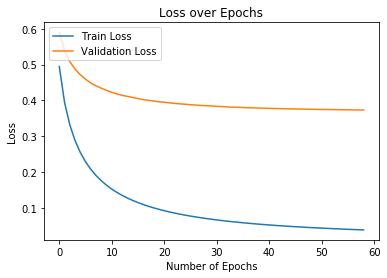

In [338]:
# fill in your code...
plt.plot(trl,label='Train Loss')
plt.plot(devl,label='Validation Loss')
plt.legend(loc="upper left")
plt.ylabel("Loss")
plt.xlabel("Number of Epochs")
plt.title("Loss over Epochs")
plt.show()

Now plot the training and validation history per epoch. Does your model underfit, overfit or is it about right? Explain why.

The model can be shown to be overfitting the data. This can be see by the differetn rate of loss between the validation and training losses. The rate of training loss is greater than that of the validation loss and the gap between plots increases overtime.

Compute accuracy, precision, recall and F1-scores:

In [339]:
# Make Predictions
preds_te_tfidf = predict_class(X_test_tfidf, w_tfidf)
preds_te_tfidf = preds_te_tfidf.squeeze()//1

print("Confusion Matrix")
print(conf(preds_te_tfidf, Y_test))
print('Accuracy:', accuracy_score(Y_test, preds_te_tfidf))
print('Precision:', precision_score(Y_test, preds_te_tfidf))
print('Recall:', recall_score(Y_test, preds_te_tfidf))
print('F1-Score:', f1_score(Y_test, preds_te_tfidf))

Confusion Matrix
[[171.  29.]
 [ 23. 177.]]
Accuracy: 0.87
Precision: 0.8592233009708737
Recall: 0.885
F1-Score: 0.8719211822660098


Print top-10 most positive and negative words:

In [340]:
pos = np.argsort(w_tfidf)[0][::-1]
neg = np.argsort(w_tfidf)[0]
print("Most Positive: ")
print([v_id[x] for x in pos[:10]])
print("Most Negative: ")
print([v_id[x] for x in neg[:10]])

Most Positive: 
[('hilarious',), ('terrific',), ('memorable',), ('excellent',), ('perfectly',), ('fun',), ('great',), ('enjoyed',), ('perfect',), ('superb',)]
Most Negative: 
[('bad',), ('worst',), ('boring',), ('supposed',), ('waste',), ('ridiculous',), ('poor',), ('minute',), ('stupid',), ('fails',)]


comment on whether they make sense:

These words make sense. Furthermore, all these features express sentiment unlike the raw count features which epressed several features that were context specific to movie reviews

If we were to apply the classifier we've learned into a different domain such laptop reviews or restaurant reviews, do you think these features would generalise well? Can you propose what features the classifier could pick up as important in the new domain?

These features suggest that this model could perform/generalise well in other domains such as laptop reviews as all these features express sentiment. For exaple, features like "excellent" and "worst". 

### Discuss how did you choose model hyperparameters (e.g. learning rate and regularisation strength)? What is the relation between training epochs and learning rate? How the regularisation strength affects performance?

I chose my hyperparameters by using a very basic grid-search to go through a range of values (The ranges for both models were arbitrary for both models due to time taken to train the models). I went through each pair of values and evaluated its F1 score. I chose the pair that produced the highest F1 Score. If I had more time I would have tested more values as well as calculated an average for each pair to remove anomalous values.

Smaller learning rates require more training epochs as each update only changes the weights a little, whereas larger learning rates result in larger jumps so require fewer epochs.

A Regularisation value is a measure of the model's complexity. A Regularisation value encourages a model's weights, as well as its mean, to tend to zero. However, there is a trade-off with a large or small regularisation value. Too large and the model runs the risk of underfitting the data, and too small runs the risk of overfitting the data.



## Full Results

Add here your results: to 3.s.f

| LR | Precision  | Recall  | F1-Score  |
|:-:|:-:|:-:|:-:|
| BOW-count  | 0.819 | 0.885 |  0.851 |
| BOW-tfidf  |  0.859 | 0.885 | 0.872  |


# Multi-class Logistic Regression 

Now you need to train a Multiclass Logistic Regression (MLR) Classifier by extending the Binary model you developed above. You will use the MLR model to perform topic classification on the AG news dataset consisting of three classes:

- Class 1: World
- Class 2: Sports
- Class 3: Business

You need to follow the same process as in Task 1 for data processing and feature extraction by reusing the functions you wrote.

In [341]:
# LOAD TRAINING DATA
data_topic_train_data = list(data_topic_train.loc[:,"Text"])
Y_tr = np.array(data_topic_train.loc[:,"Label"])

# LOAD TEST DATA
data_topic_test_data = list(data_topic_test.loc[:,"Text"])
Y_test = np.array(data_topic_test.loc[:,"Label"])

# LOAD VALIDATION DATA
data_topic_dev_data = list(data_topic_dev.loc[:,"Text"])
Y_dev = np.array(data_topic_dev.loc[:,"Label"])

In [342]:
# Extract the new vocab, document frequencies, and counts
vocab, df, ngram_counts = get_vocab(data_topic_train_data, ngram_range=(1,3), keep_topN=5000, stop_words=stop_words)

v_id = {i: v for i, v in enumerate(vocab)}
w_id = {v: i for i, v in v_id.items()}

# GET dicts for the data
tr_ngram_count = [extract_ngrams(x, stop_words=stop_words) for x in data_topic_train_data]
dev_ngram_count = [extract_ngrams(x, stop_words=stop_words) for x in data_topic_dev_data]
test_ngram_count = [extract_ngrams(x, stop_words=stop_words) for x in data_topic_test_data]

# TRAINING COUNT MATRIX
X_tr_count = vectorise(tr_ngram_count, vocab)
# DEV COUNT MATRIX
X_dev_count = vectorise(dev_ngram_count, vocab)
# TEST COUNT MATRIX
X_test_count = vectorise(test_ngram_count, vocab)


no_docs = len(tr_ngram_count)
idf = tfidf(no_docs, df, v_id)
# Get tf.idf bag-of-words
X_tr_tfidf = np.log10(1 + X_tr_count) * idf
X_dev_tfidf = np.log10(1 + X_dev_count) * idf
X_test_tfidf = np.log10(1 + X_test_count) * idf



Now you need to change `SGD` to support multiclass datasets. First you need to develop a `softmax` function. It takes as input:

- `z`: array of real numbers 

and returns:

- `smax`: the softmax of `z`

In [343]:
def softmax(z):
    # Subtract the max value in z to all elements 
    # Too make the function numerically stable with large numbers     
    z -= np.max(z)
    smax = np.exp(z) / np.sum(np.exp(z))
    
    return smax

Then modify `predict_proba` and `predict_class` functions for the multiclass case:

In [344]:
def predict_proba(X, weights):
    # Obtain the probabilties using softmax    
    preds_proba = np.dot(X, weights.T)
    preds_proba = softmax(preds_proba)
    return preds_proba

In [345]:
def predict_class(X, weights):
    # Predict the class using argmax     
    preds_class = predict_proba(X, weights)
    pre = np.argmax(preds_class, axis=1)
    return pre

Toy example and expected functionality of the functions above:

In [346]:
X = np.array([[0.1,0.2],[0.2,0.1],[0.1,-0.2]])
w = np.array([[2,-5],[-5,2]])

print(X.shape, w.shape)

(3, 2) (2, 2)


In [347]:
predict_proba(X, w)

array([[0.06982558, 0.14061145],
       [0.14061145, 0.06982558],
       [0.51594513, 0.0631808 ]])

In [348]:
predict_class(X, w)

array([1, 0, 0])

Now you need to compute the categorical cross entropy loss (extending the binary loss to support multiple classes).

In [349]:
def categorical_loss_dev(X, Y, weights, num_classes=5, alpha=0.00001):

    # init loss 
    loss = np.zeros(shape=(weights.shape))
    # Calculate probabilities     
    prob = predict_proba(X, weights)
    
    # Calculate the derivative of the loss     
    loss[Y] = X * (prob[Y] - 1)
    
    # Apply the derived regulisation term to the loss    
    return loss + 2 * alpha * weights

    

In [350]:
def categorical_loss(X, Y, weights, num_classes=5, alpha=0.00001):
    
    # init loss 
    loss = 0
    # Calculate the loss for each document in X    
    for i, y in enumerate(Y) :  
        prob = predict_proba(X[i], weights)
        loss += -np.log(prob[y])
    
    # Return the average loss + regulisation term     
    return loss/len(Y) + alpha * np.sum(weights**2)

Finally you need to modify SGD to support the categorical cross entropy loss:

In [351]:
def SGD(X_tr, Y_tr, X_dev=[], Y_dev=[], num_classes=5, lr=0.01, alpha=0.00001, epochs=5, tolerance=0.001, print_progress=True):
    

    training_loss_history = []
    validation_loss_history = []
    
    #  Init weights with zeros   
    weights = np.zeros(shape=(num_classes, X_tr.shape[1]))
    
    # For each epoch     
    for e in range(epochs) :
        
        # Shuffle documents         
        s = np.arange(0, len(Y_tr))
        np.random.shuffle(s)
        
        # Shuffle the order of the docs        
        X = np.array(X_tr)[s]
        Y = np.array(Y_tr)[s]
        
        # For each document calculate the gradient and descend        
        for i, x in enumerate(X) :
            weights -= lr * categorical_loss_dev(x, Y[i], weights, alpha=alpha, num_classes=num_classes)
        
        # record losses      
        training_loss_history.append(categorical_loss(X_tr, Y_tr, weights, alpha=alpha, num_classes=num_classes))   
        validation_loss_history.append(categorical_loss(X_dev, Y_dev, weights, alpha=alpha, num_classes=num_classes))
        
        if print_progress :
            print("Epoch:", e,"| Training loss:", training_loss_history[e],"| Validation loss:", validation_loss_history[e])
        
        # Stop when the difference between the current and previous validation loss is smaller than a threshold      
        if e > 1 and np.abs(validation_loss_history[e - 1] - validation_loss_history[e]) < tolerance :
            break

    return weights, training_loss_history, validation_loss_history

Now you are ready to train and evaluate you MLR following the same steps as in Task 1 for both Count and tfidf features:

In [352]:
"""

A Naïve form of a grid-search to find good hyperparameters

"""
learning_rate = np.logspace(-1, -3, 3)
alpha = np.logspace(-4, -6, 3)

# Save best params in a hash
best = {"learning_rate" : 0, "Alpha" : 0, "f1" : 0} 

# for each hyperparameter
for rate in learning_rate :
    for al in alpha :
        print(rate,al)
        w_count, loss_tr_count, dev_loss_count = SGD(X_tr_count, Y_tr - 1, 
                                                X_dev=X_dev_count, 
                                                Y_dev=Y_dev - 1, 
                                                num_classes=3,
                                                epochs=100,
                                                lr=rate,
                                                alpha=al,
                                                print_progress=False)
        # Evaluate  
        p = predict_class(X_test_count, w_count)
        f1 = f1_score(Y_test - 1, p.squeeze(), average='macro')
              
        if f1 > best["f1"]:
             best = {"learning_rate" : rate, "Alpha" : al, "f1" : f1}
                    
print("Final", best)

0.1 0.0001
0.1 1e-05
0.1 1e-06
0.01 0.0001
0.01 1e-05
0.01 1e-06
0.001 0.0001
0.001 1e-05
0.001 1e-06
Final {'learning_rate': 0.001, 'Alpha': 0.0001, 'f1': 0.8688188195620731}


In [353]:
# Use searched hyperparameters
w_count, loss_tr_count, dev_loss_count = SGD(X_tr_count, Y_tr-1, 
                                             X_dev=X_dev_count, 
                                             Y_dev=Y_dev-1 ,
                                             num_classes=3,
                                             lr=best["learning_rate"],
                                             alpha=best["Alpha"],
                                             epochs=200)

Epoch: 0 | Training loss: 0.9757768363812795 | Validation loss: 1.0386695889431747
Epoch: 1 | Training loss: 0.8926981578077007 | Validation loss: 0.9915021094077285
Epoch: 2 | Training loss: 0.8297093908700244 | Validation loss: 0.9517713198533554
Epoch: 3 | Training loss: 0.7796362357383748 | Validation loss: 0.9175156363086793
Epoch: 4 | Training loss: 0.7385052031713584 | Validation loss: 0.8874697731130149
Epoch: 5 | Training loss: 0.7039765172202689 | Validation loss: 0.86092390272327
Epoch: 6 | Training loss: 0.674362156427306 | Validation loss: 0.8372038441068257
Epoch: 7 | Training loss: 0.6485951027460155 | Validation loss: 0.8158823529934582
Epoch: 8 | Training loss: 0.6259005925214388 | Validation loss: 0.7965818506770842
Epoch: 9 | Training loss: 0.6056955285733022 | Validation loss: 0.7790102780790952
Epoch: 10 | Training loss: 0.5875520023977826 | Validation loss: 0.7629329082673548
Epoch: 11 | Training loss: 0.571147567731156 | Validation loss: 0.7481632686067579
Epoch:

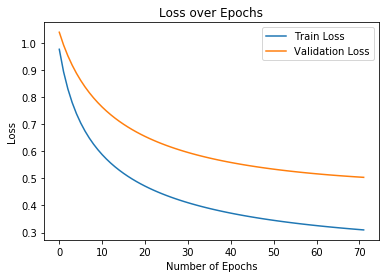

In [354]:
plt.plot(loss_tr_count,label='Train Loss')
plt.plot(dev_loss_count,label='Validation Loss')
plt.legend(loc="upper right")
plt.ylabel("Loss")
plt.xlabel("Number of Epochs")
plt.title("Loss over Epochs")

plt.show()


Plot training and validation process and explain if your model overfit, underfit or is about right:

This graph suggests that the model is overfitting a tiny bit. This can be see from the fact that both plots rates of loss look to be similar with only a little bit of seperation. It also suggests that that the model capacity isnt high enough so to improve this model would be to increase the number of parameters

Compute accuracy, precision, recall and F1-scores:

In [355]:
# predict
preds_te = predict_class(X_test_count, w_count).squeeze()

print("Confusion Matix")
print(conf(preds_te, Y_test - 1))
print('Accuracy:', accuracy_score(Y_test - 1, preds_te))
print('Precision:', precision_score(Y_test - 1, preds_te, average='macro'))
print('Recall:', recall_score(Y_test - 1, preds_te, average='macro'))
print('F1-Score:', f1_score(Y_test - 1, preds_te, average='macro'))

Confusion Matix
[[260.  18.  22.]
 [ 14. 281.   5.]
 [ 51.   8. 241.]]
Accuracy: 0.8688888888888889
Precision: 0.8715210591991184
Recall: 0.8688888888888888
F1-Score: 0.8688188195620731


Print the top-10 words for each class respectively.

In [356]:
one = np.argsort(w_count)[0][::-1]
two = np.argsort(w_count)[1][::-1]
three = np.argsort(w_count)[2][::-1]
print("Class One: ")
print([v_id[x] for x in one][:10])
print()
print("Class Two: ")
print([v_id[x] for x in two][:10])
print()
print("Class Three: ")
print([v_id[x] for x in three][:10])

Class One: 
[('reuters',), ('athens',), ('oil',), ('afp',), ('president',), ('prices',), ('greece',), ('olympic',), ('athens', 'greece'), ('united',)]

Class Two: 
[('athens',), ('reuters',), ('olympic',), ('team',), ('night',), ('win',), ('gold',), ('games',), ('olympics',), ('year',)]

Class Three: 
[('reuters',), ('oil',), ('prices',), ('company',), ('york',), ('year',), ('percent',), ('quot',), ('oil', 'prices'), ('billion',)]


comment on whether they make sense:
These features make sense. Class One includes features related to "World"; Class Two includes features related to "Sports"; and Class Three includes features related to "Business". However, there are a lot of overlap accross classes. For example the feature "reuters" is in the top 2 for all classes.

If we were to apply the classifier we've learned into a different domain such laptop reviews or restaurant reviews, do you think these features would generalise well? Can you propose what features the classifier could pick up as important in the new domain?

In terms of generalisability, this model would act very poorly as the model has been trained with only three specific topics. If a new topic is added, such as technology, then a new model would have to be trained to allow for this increase of classifier output otherwise misclassification will occur. However, in terms of classifing other news items from different sources could perform well.

### Discuss how did you choose model hyperparameters (e.g. learning rate and regularisation strength)? What is the relation between training epochs and learning rate? How the regularisation strength affects performance?

I chose my hyperparameters by using a very basic grid-search to go through a range of values (The ranges for both models were arbitrary for both models due to time taken to train the models). I went through each pair of values and evaluated its F1 score. I chose the pair that produced the highest F1 Score. If I had more time I would have tested more values as well as calculated an average for each pair to remove anomalous values.

Smaller learning rates require more training epochs as each update only changes the weights a little, whereas larger learning rates result in larger jumps so require fewer epochs.

A Regularisation value is a measure of the model's complexity. A Regularisation value encourages a model's weights, as well as its mean, to tend to zero. However, there is a trade-off with a large or small regularisation value. Too large and the model runs the risk of underfitting the data, and too small runs the risk of overfitting the data.

In [357]:
# Init hyperparam space
learning_rate = np.logspace(-1, -3, 3)
alpha = np.logspace(-4, -6, 3)

# Save best hyperparams in hash
best = {"learning_rate" : 0, "Alpha" : 0, "f1" : 0} 

# for each hyperparam
for rate in learning_rate :
    for al in alpha :
        print(rate,al)
        w_tfidf, trl, devl = SGD(X_tr_tfidf, Y_tr - 1, 
                                 X_dev=X_dev_tfidf, 
                                 Y_dev=Y_dev - 1, 
                                 epochs=100,
                                 lr = rate,
                                 alpha=al,
                                print_progress=False)
        # Evaluate         
        p = predict_class(X_test_tfidf, w_tfidf)
        f1 = f1_score(Y_test - 1, p.squeeze(), average='macro')
        if f1 > best["f1"]:
             best = {"learning_rate" : rate, "Alpha" : al, "f1" : f1}
                    
print("Final", best)

0.1 0.0001
0.1 1e-05
0.1 1e-06
0.01 0.0001
0.01 1e-05
0.01 1e-06
0.001 0.0001
0.001 1e-05
0.001 1e-06
Final {'learning_rate': 0.001, 'Alpha': 0.0001, 'f1': 0.8815144683496156}


In [358]:
w_tfidf, trl, devl = SGD(X_tr_tfidf, Y_tr - 1, 
                         X_dev=X_dev_tfidf, 
                         Y_dev=Y_dev - 1,
                         lr = best["learning_rate"],
                         alpha=best["Alpha"],
                         epochs=100)

Epoch: 0 | Training loss: 1.5492263439697442 | Validation loss: 1.5768520621001325
Epoch: 1 | Training loss: 1.4934446766651297 | Validation loss: 1.5457703268156944
Epoch: 2 | Training loss: 1.4419061909969957 | Validation loss: 1.5161481322155956
Epoch: 3 | Training loss: 1.3942758378850744 | Validation loss: 1.4879227746088652
Epoch: 4 | Training loss: 1.3501164632679352 | Validation loss: 1.461004407356531
Epoch: 5 | Training loss: 1.3090097042466897 | Validation loss: 1.4352855721102482
Epoch: 6 | Training loss: 1.2706538662217488 | Validation loss: 1.410697284381645
Epoch: 7 | Training loss: 1.2347668122281623 | Validation loss: 1.387161985251461
Epoch: 8 | Training loss: 1.2011057480990865 | Validation loss: 1.3646076730633991
Epoch: 9 | Training loss: 1.1694880963994736 | Validation loss: 1.3429824160905175
Epoch: 10 | Training loss: 1.139736639195379 | Validation loss: 1.3222297140437207
Epoch: 11 | Training loss: 1.111701414481293 | Validation loss: 1.302309301193003
Epoch: 1

Epoch: 98 | Training loss: 0.46305594385827775 | Validation loss: 0.7087713753477446
Epoch: 99 | Training loss: 0.4610914881749136 | Validation loss: 0.7065373937302709


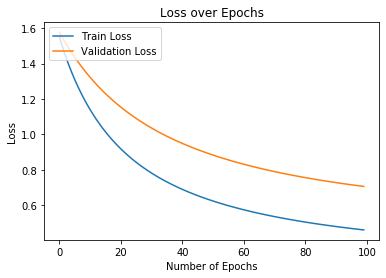

In [359]:
plt.plot(trl,label='Train Loss')
plt.plot(devl,label='Validation Loss')
plt.legend(loc="upper left")
plt.ylabel("Loss")
plt.xlabel("Number of Epochs")
plt.title("Loss over Epochs")

plt.show()

Plot training and validation process and explain if your model overfit, underfit or is about right:

This graph suggests that the model is overfitting a tiny bit. This can be see from the fact that both plots rates of loss look to be similar with only a little bit of seperation. It also suggests that that the model capacity isnt high enough so to improve this model would be to increase the number of parameters

In [360]:
preds_te = predict_class(X_test_tfidf, w_tfidf).squeeze()

print("Confusion Matix")
print(conf(preds_te, Y_test - 1))

print('Accuracy:', accuracy_score(Y_test - 1, preds_te))
print('Precision:', precision_score(Y_test - 1, preds_te, average='macro'))
print('Recall:', recall_score(Y_test - 1, preds_te, average='macro'))
print('F1-Score:', f1_score(Y_test - 1, preds_te, average='macro'))

Confusion Matix
[[258.  21.  21.]
 [  7. 290.   3.]
 [ 45.   9. 246.]]
Accuracy: 0.8822222222222222
Precision: 0.8832063918757468
Recall: 0.8822222222222221
F1-Score: 0.8815144683496156


In [361]:
one = np.argsort(w_tfidf)[0][::-1]
two = np.argsort(w_tfidf)[1][::-1]
three = np.argsort(w_tfidf)[2][::-1]
print("Class One: ")
print([v_id[x] for x in one][:10])
print()
print("Class Two: ")
print([v_id[x] for x in two][:10])
print()
print("Class Three: ")

print([v_id[x] for x in three][:10])

Class One: 
[('afp',), ('president',), ('reuters',), ('people',), ('government',), ('city',), ('iraq',), ('officials',), ('minister',), ('united',)]

Class Two: 
[('athens',), ('olympic',), ('team',), ('night',), ('games',), ('olympics',), ('win',), ('gold',), ('athens', 'reuters'), ('season',)]

Class Three: 
[('company',), ('oil',), ('reuters',), ('prices',), ('york',), ('percent',), ('billion',), ('corp',), ('business',), ('sales',)]


comment on whether they make sense:
These features make sense. Class One includes features related to "World"; Class Two includes features related to "Sports"; and Class Three includes features related to "Business". 

Compared to the raw count features these features have a lot less overlap and each class seems to be a lot more context specific. This can be seen in the increased F1-score.

If we were to apply the classifier we've learned into a different domain such laptop reviews or restaurant reviews, do you think these features would generalise well? Can you propose what features the classifier could pick up as important in the new domain?

In terms of generalisability, this model would act very poorly as the model has been trained with only three specific topics. If a new topic is added, such as technology, then a new model would have to be trained to allow for this increase of classifier output otherwise misclassification will occur. However, in terms of classifing other news items from different sources could perform well.

### Discuss how did you choose model hyperparameters (e.g. learning rate and regularisation strength)? What is the relation between training epochs and learning rate? How the regularisation strength affects performance?

I chose my hyperparameters by using a very basic grid-search to go through a range of values (The ranges for both models were arbitrary for both models due to time taken to train the models). I went through each pair of values and evaluated its F1 score. I chose the pair that produced the highest F1 Score. If I had more time I would have tested more values as well as calculated an average for each pair to remove anomalous values.

Smaller learning rates require more training epochs as each update only changes the weights a little, whereas larger learning rates result in larger jumps so require fewer epochs.

A Regularisation value is a measure of the model's complexity. A Regularisation value encourages a model's weights, as well as its mean, to tend to zero. However, there is a trade-off with a large or small regularisation value. Too large and the model runs the risk of underfitting the data, and too small runs the risk of overfitting the data.

## Full Results

Add here your results: to 3s.f.

| LR | Precision  | Recall  | F1-Score  |
|:-:|:-:|:-:|:-:|
| BOW-count  |  0.872 | 0.869|  0.869|
| BOW-tfidf  | 0.883  |  0.882| 0.882 |


In [362]:
current_time = datetime.now() - now
print("Total Time =", current_time)

Total Time = 0:15:42.337432
